# Compare All Models: Random Forest, LSTM, and Transformer

This notebook compares the performance of all three models on RUL prediction:
- **Random Forest**: Tree-based ensemble model
- **LSTM (PyTorch)**: Recurrent neural network with sequence learning
- **Transformer (PyTorch)**: Attention-based model for temporal patterns

**Phase 1**: Point prediction comparison only.


In [3]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# PyTorch for loading LSTM and Transformer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("✅ Setup complete")


✅ Setup complete


In [4]:
# Load all model predictions and metrics
models_dir = project_root / "results" / "models"

# Load Random Forest results
rf_metrics = pd.read_csv(models_dir / "rf_metrics_point.csv")
rf_predictions = pd.read_csv(models_dir / "rf_predictions_point.csv")
print("✅ Loaded Random Forest results")

# Load LSTM results
lstm_metrics = pd.read_csv(models_dir / "lstm_pytorch_metrics_point.csv")
lstm_predictions = pd.read_csv(models_dir / "lstm_pytorch_predictions_point.csv")
print("✅ Loaded LSTM results")

# Load Transformer results
transformer_metrics = pd.read_csv(models_dir / "transformer_metrics_point.csv")
transformer_predictions = pd.read_csv(models_dir / "transformer_predictions_point.csv")
print("✅ Loaded Transformer results")

print(f"\nTest set size: {len(rf_predictions)} samples")


✅ Loaded Random Forest results
✅ Loaded LSTM results
✅ Loaded Transformer results

Test set size: 250 samples


In [5]:
# Create comprehensive comparison table
comparison_data = {
    'Model': ['Random Forest', 'LSTM (PyTorch)', 'Transformer (PyTorch)'],
    'Test MAE': [
        rf_metrics[rf_metrics['metric'] == 'MAE']['test'].values[0],
        lstm_metrics[lstm_metrics['metric'] == 'MAE']['test'].values[0],
        transformer_metrics[transformer_metrics['metric'] == 'MAE']['test'].values[0]
    ],
    'Test RMSE': [
        rf_metrics[rf_metrics['metric'] == 'RMSE']['test'].values[0],
        lstm_metrics[lstm_metrics['metric'] == 'RMSE']['test'].values[0],
        transformer_metrics[transformer_metrics['metric'] == 'RMSE']['test'].values[0]
    ],
    'Test R²': [
        rf_metrics[rf_metrics['metric'] == 'R²']['test'].values[0],
        lstm_metrics[lstm_metrics['metric'] == 'R²']['test'].values[0],
        transformer_metrics[transformer_metrics['metric'] == 'R²']['test'].values[0]
    ],
    'Test MAPE': [
        rf_metrics[rf_metrics['metric'] == 'MAPE']['test'].values[0],
        lstm_metrics[lstm_metrics['metric'] == 'MAPE']['test'].values[0],
        transformer_metrics[transformer_metrics['metric'] == 'MAPE']['test'].values[0]
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Format for display
print("="*80)
print("MODEL COMPARISON: Test Set Performance")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model for each metric
print("\n📊 Best Model by Metric:")
print(f"  Best MAE:  {comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Model']} ({comparison_df['Test MAE'].min():.2f} cycles)")
print(f"  Best RMSE: {comparison_df.loc[comparison_df['Test RMSE'].idxmin(), 'Model']} ({comparison_df['Test RMSE'].min():.2f} cycles)")
print(f"  Best R²:   {comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']} ({comparison_df['Test R²'].max():.3f})")

# Save comparison table
comparison_df.to_csv(models_dir / "model_comparison_point.csv", index=False)
print(f"\n✅ Saved comparison table: {models_dir / 'model_comparison_point.csv'}")


MODEL COMPARISON: Test Set Performance
                Model  Test MAE  Test RMSE   Test R²    Test MAPE
        Random Forest 21.279240  27.893753 -0.055334 4.216689e+07
       LSTM (PyTorch) 16.738613  20.348142  0.158573 2.520360e+07
Transformer (PyTorch) 19.063660  23.582616 -0.130188 2.451036e+07

📊 Best Model by Metric:
  Best MAE:  LSTM (PyTorch) (16.74 cycles)
  Best RMSE: LSTM (PyTorch) (20.35 cycles)
  Best R²:   LSTM (PyTorch) (0.159)

✅ Saved comparison table: /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/model_comparison_point.csv


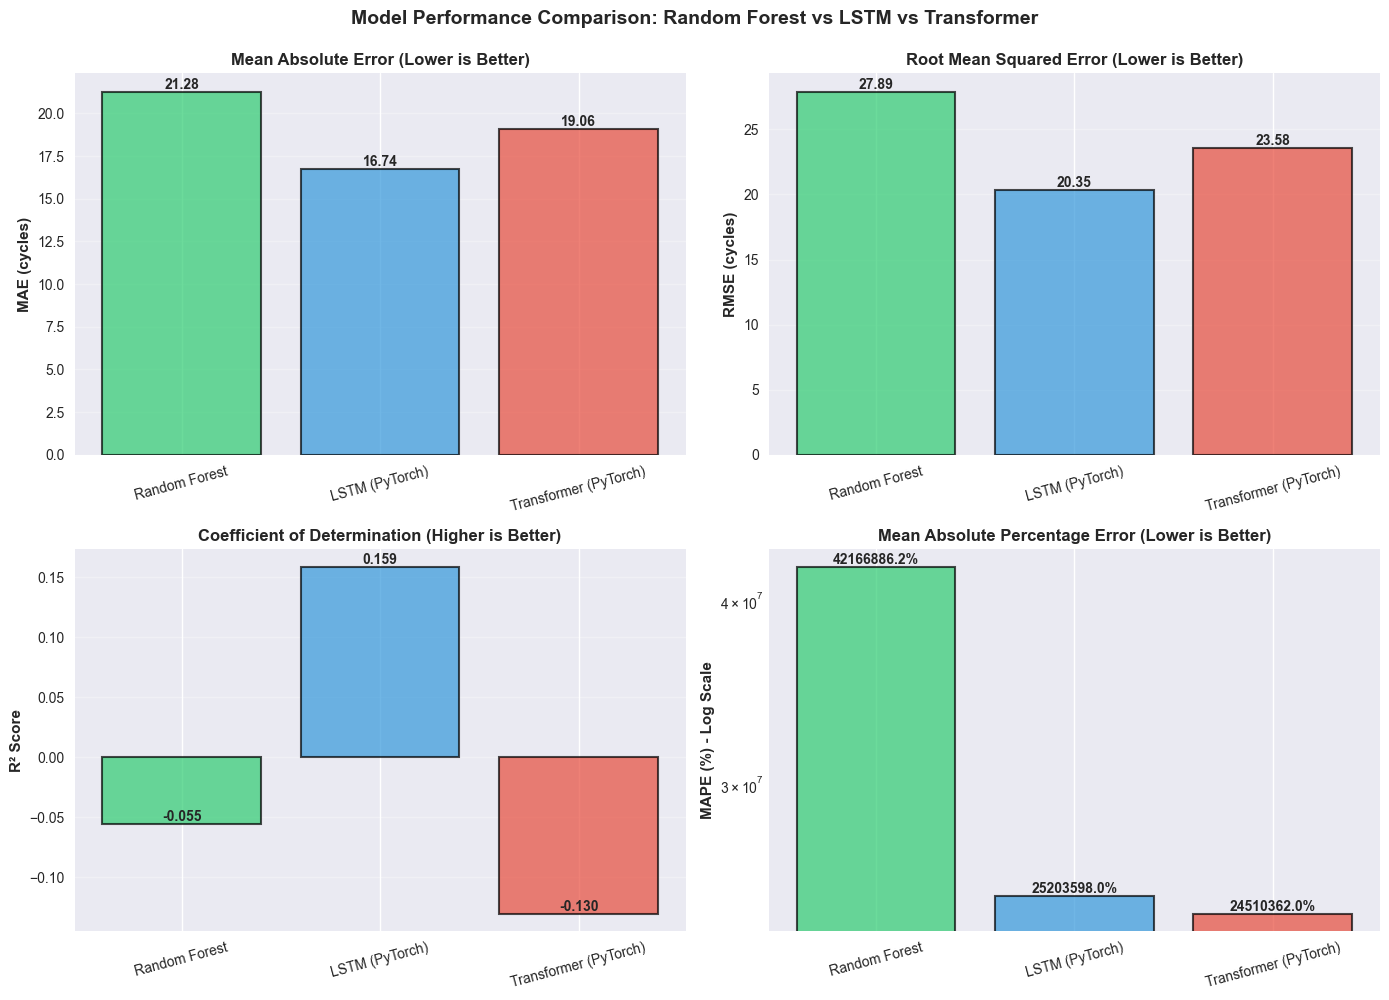

✅ Metrics comparison visualization saved


In [6]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = comparison_df['Model'].values
colors = ['#2ecc71', '#3498db', '#e74c3c']

# MAE comparison
axes[0, 0].bar(models, comparison_df['Test MAE'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('MAE (cycles)', fontweight='bold', fontsize=11)
axes[0, 0].set_title('Mean Absolute Error (Lower is Better)', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Test MAE']):
    axes[0, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
axes[0, 1].bar(models, comparison_df['Test RMSE'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('RMSE (cycles)', fontweight='bold', fontsize=11)
axes[0, 1].set_title('Root Mean Squared Error (Lower is Better)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Test RMSE']):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# R² comparison
axes[1, 0].bar(models, comparison_df['Test R²'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('R² Score', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Coefficient of Determination (Higher is Better)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=15)
for i, v in enumerate(comparison_df['Test R²']):
    axes[1, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# MAPE comparison (log scale if needed)
mape_values = comparison_df['Test MAPE'].values
if mape_values.max() > 100:
    axes[1, 1].bar(models, mape_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1, 1].set_yscale('log')
    axes[1, 1].set_ylabel('MAPE (%) - Log Scale', fontweight='bold', fontsize=11)
else:
    axes[1, 1].bar(models, mape_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1, 1].set_ylabel('MAPE (%)', fontweight='bold', fontsize=11)
axes[1, 1].set_title('Mean Absolute Percentage Error (Lower is Better)', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=15)
for i, v in enumerate(mape_values):
    axes[1, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Performance Comparison: Random Forest vs LSTM vs Transformer', 
             fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()

# Save figure
viz_dir = project_root / 'results' / 'visualizations'
viz_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_dir / '05_model_comparison_metrics.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Metrics comparison visualization saved")


Using 190 samples for comparison (minimum across all models)


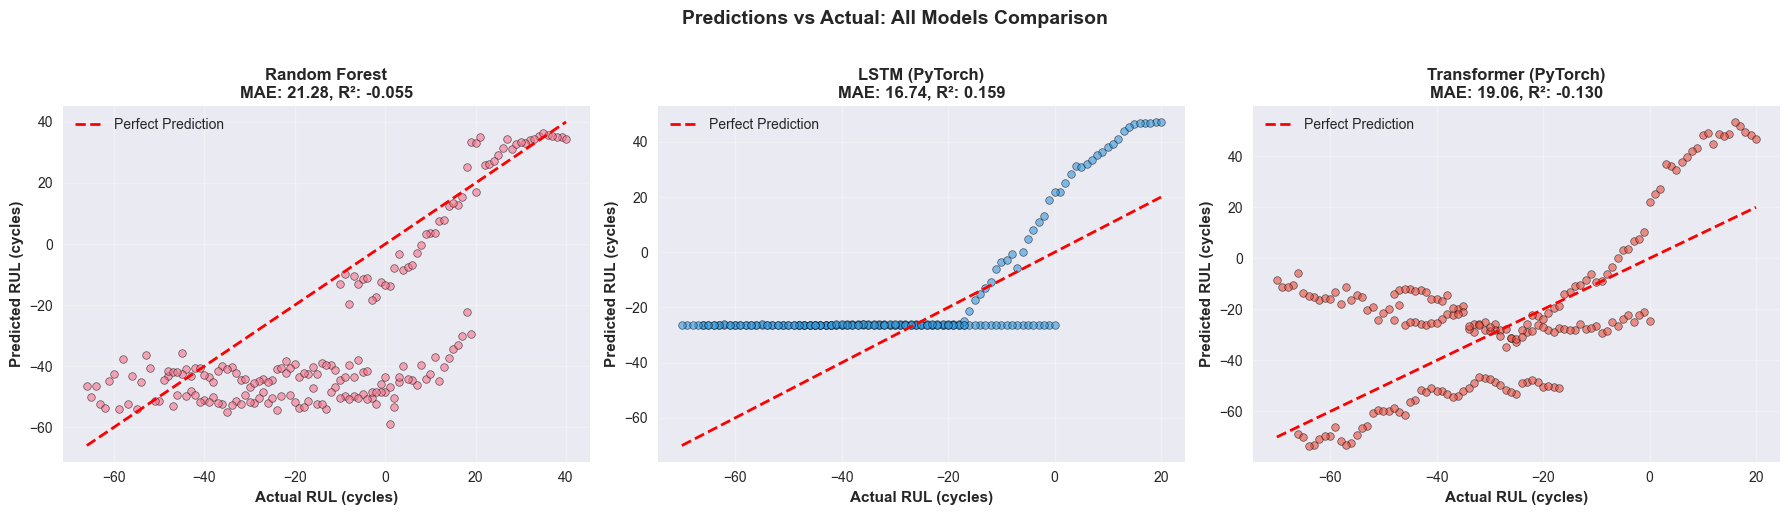

✅ Predictions comparison visualization saved


In [8]:
# Compare predictions vs actual for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Find minimum length across all prediction arrays (they may differ due to sequence requirements)
min_length = min(len(rf_predictions), len(lstm_predictions), len(transformer_predictions))
print(f"Using {min_length} samples for comparison (minimum across all models)")

# Sample for visualization (if too many points)
n_samples = min(200, min_length)
sample_idx = np.random.choice(min_length, n_samples, replace=False)

# Random Forest (use first min_length samples to align)
y_actual_rf = rf_predictions['actual_rul'].values[:min_length][sample_idx]
y_pred_rf = rf_predictions['predicted_rul'].values[:min_length][sample_idx]
axes[0].scatter(y_actual_rf, y_pred_rf, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].plot([y_actual_rf.min(), y_actual_rf.max()], [y_actual_rf.min(), y_actual_rf.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL (cycles)', fontweight='bold')
axes[0].set_ylabel('Predicted RUL (cycles)', fontweight='bold')
axes[0].set_title(f'Random Forest\nMAE: {rf_metrics[rf_metrics["metric"]=="MAE"]["test"].values[0]:.2f}, R²: {rf_metrics[rf_metrics["metric"]=="R²"]["test"].values[0]:.3f}', 
                  fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LSTM (already aligned to min_length)
y_actual_lstm = lstm_predictions['actual_rul'].values[sample_idx]
y_pred_lstm = lstm_predictions['predicted_rul'].values[sample_idx]
axes[1].scatter(y_actual_lstm, y_pred_lstm, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color='#3498db')
axes[1].plot([y_actual_lstm.min(), y_actual_lstm.max()], [y_actual_lstm.min(), y_actual_lstm.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual RUL (cycles)', fontweight='bold')
axes[1].set_ylabel('Predicted RUL (cycles)', fontweight='bold')
axes[1].set_title(f'LSTM (PyTorch)\nMAE: {lstm_metrics[lstm_metrics["metric"]=="MAE"]["test"].values[0]:.2f}, R²: {lstm_metrics[lstm_metrics["metric"]=="R²"]["test"].values[0]:.3f}', 
                  fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Transformer (already aligned to min_length)
y_actual_trans = transformer_predictions['actual_rul'].values[sample_idx]
y_pred_trans = transformer_predictions['predicted_rul'].values[sample_idx]
axes[2].scatter(y_actual_trans, y_pred_trans, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color='#e74c3c')
axes[2].plot([y_actual_trans.min(), y_actual_trans.max()], [y_actual_trans.min(), y_actual_trans.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_xlabel('Actual RUL (cycles)', fontweight='bold')
axes[2].set_ylabel('Predicted RUL (cycles)', fontweight='bold')
axes[2].set_title(f'Transformer (PyTorch)\nMAE: {transformer_metrics[transformer_metrics["metric"]=="MAE"]["test"].values[0]:.2f}, R²: {transformer_metrics[transformer_metrics["metric"]=="R²"]["test"].values[0]:.3f}', 
                  fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Predictions vs Actual: All Models Comparison', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()

# Save figure
plt.savefig(viz_dir / '06_predictions_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Predictions comparison visualization saved")


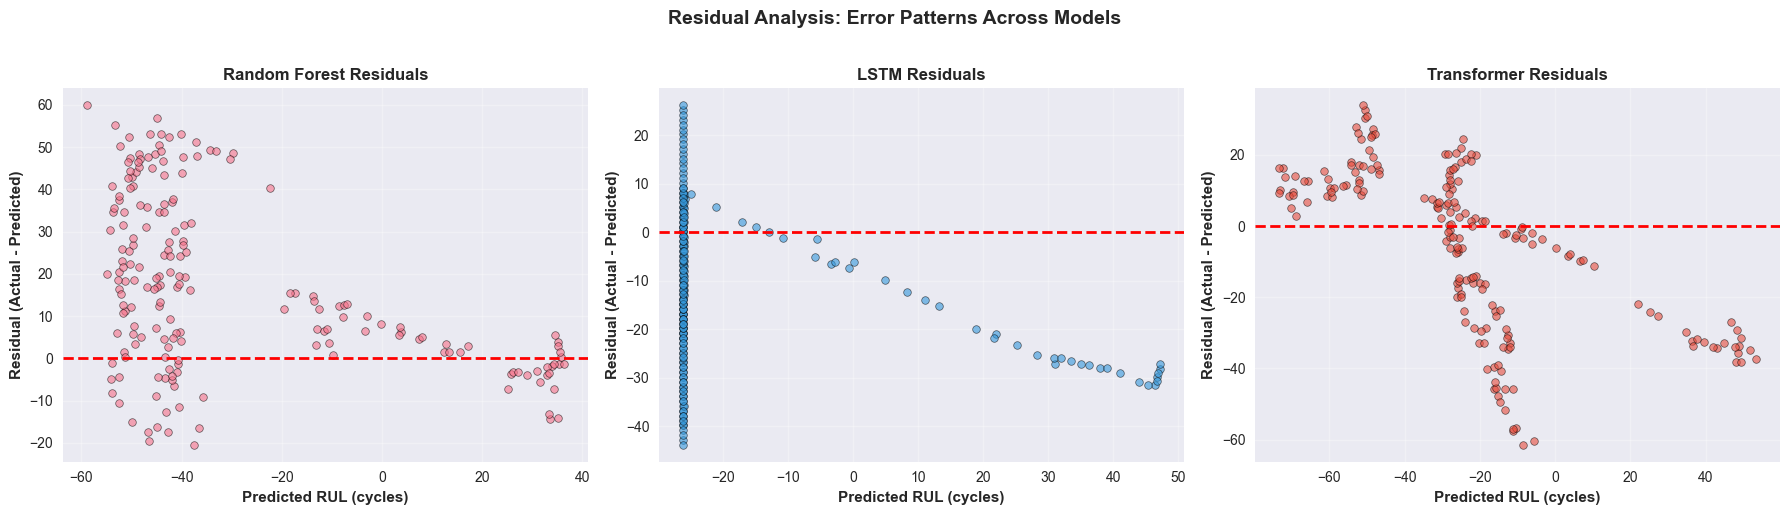

✅ Residuals comparison visualization saved


In [9]:
# Compare residuals (errors) for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Calculate residuals
residuals_rf = y_actual_rf - y_pred_rf
residuals_lstm = y_actual_lstm - y_pred_lstm
residuals_trans = y_actual_trans - y_pred_trans

# Random Forest residuals
axes[0].scatter(y_pred_rf, residuals_rf, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted RUL (cycles)', fontweight='bold')
axes[0].set_ylabel('Residual (Actual - Predicted)', fontweight='bold')
axes[0].set_title('Random Forest Residuals', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# LSTM residuals
axes[1].scatter(y_pred_lstm, residuals_lstm, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color='#3498db')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted RUL (cycles)', fontweight='bold')
axes[1].set_ylabel('Residual (Actual - Predicted)', fontweight='bold')
axes[1].set_title('LSTM Residuals', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Transformer residuals
axes[2].scatter(y_pred_trans, residuals_trans, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color='#e74c3c')
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[2].set_xlabel('Predicted RUL (cycles)', fontweight='bold')
axes[2].set_ylabel('Residual (Actual - Predicted)', fontweight='bold')
axes[2].set_title('Transformer Residuals', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Residual Analysis: Error Patterns Across Models', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()

# Save figure
plt.savefig(viz_dir / '07_residuals_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Residuals comparison visualization saved")


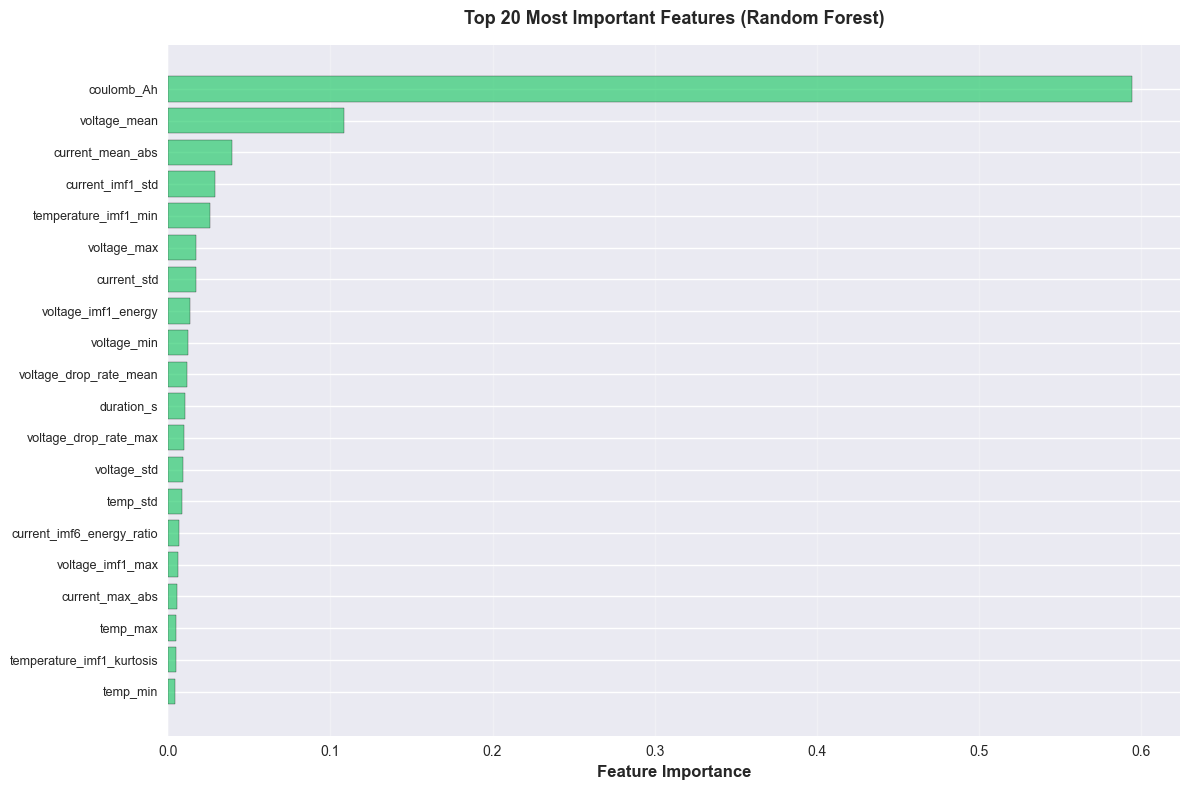

✅ Feature importance visualization saved

Top 5 Features:
  7. coulomb_Ah: 0.5944
  2. voltage_mean: 0.1086
  6. current_mean_abs: 0.0392
  26. current_imf1_std: 0.0285
  82. temperature_imf1_min: 0.0260


In [10]:
# Load Random Forest model to get feature importance
rf_model = joblib.load(models_dir / "random_forest_rul_point_model.pkl")

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': rf_model.feature_names_in_,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Get top 20 features
top_features = feature_importance.head(20)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(top_features)), top_features['importance'], color='#2ecc71', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=9)
ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Most Important Features (Random Forest)', fontweight='bold', fontsize=13, pad=15)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()

# Save figure
plt.savefig(viz_dir / '08_feature_importance.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ Feature importance visualization saved")
print(f"\nTop 5 Features:")
for i, row in top_features.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")


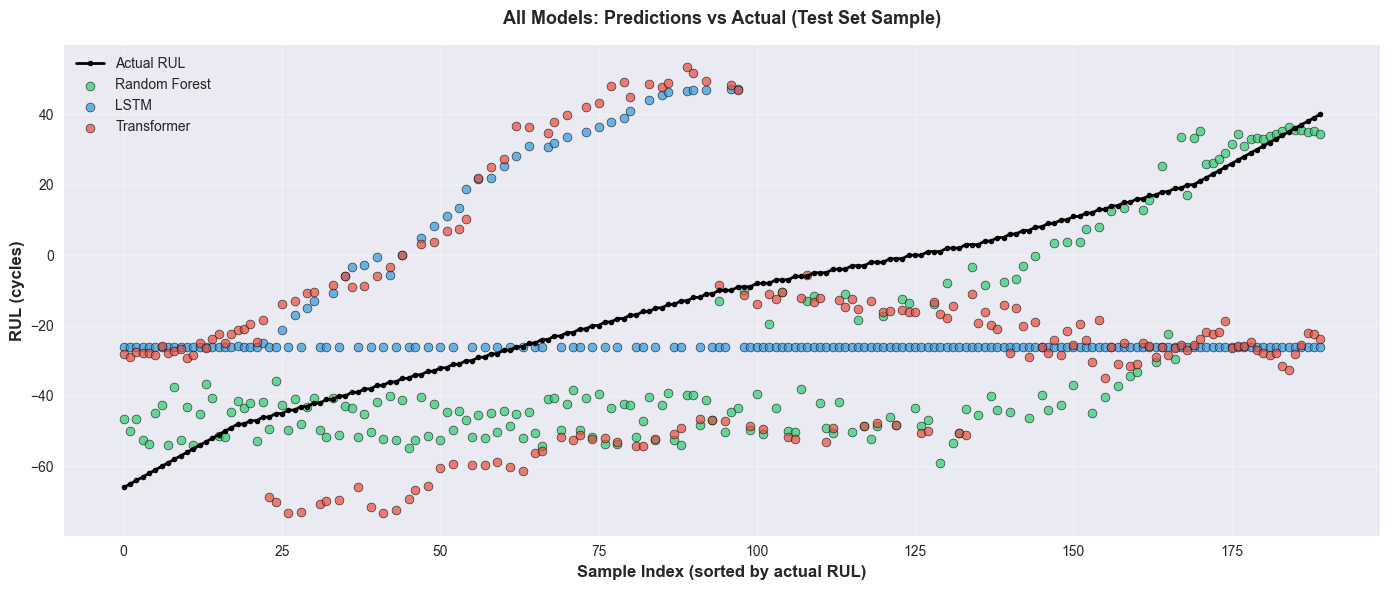

✅ All models predictions comparison saved


In [11]:
# Create side-by-side comparison of all predictions on same samples
# Use the same aligned samples from previous cell
fig, ax = plt.subplots(figsize=(14, 6))

# Sort by actual RUL for better visualization (using RF actual values)
sorted_idx = np.argsort(y_actual_rf)

x_pos = np.arange(len(sorted_idx))

# Plot all three models
ax.plot(x_pos, y_actual_rf[sorted_idx], 'ko-', linewidth=2, markersize=4, label='Actual RUL', zorder=4)
ax.scatter(x_pos, y_pred_rf[sorted_idx], alpha=0.7, s=40, label='Random Forest', color='#2ecc71', zorder=3, edgecolors='black', linewidth=0.5)
ax.scatter(x_pos, y_pred_lstm[sorted_idx], alpha=0.7, s=40, label='LSTM', color='#3498db', zorder=3, edgecolors='black', linewidth=0.5)
ax.scatter(x_pos, y_pred_trans[sorted_idx], alpha=0.7, s=40, label='Transformer', color='#e74c3c', zorder=3, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Sample Index (sorted by actual RUL)', fontweight='bold', fontsize=12)
ax.set_ylabel('RUL (cycles)', fontweight='bold', fontsize=12)
ax.set_title('All Models: Predictions vs Actual (Test Set Sample)', fontweight='bold', fontsize=13, pad=15)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
plt.savefig(viz_dir / '09_all_models_predictions.png', bbox_inches='tight', dpi=300)
plt.show()

print("✅ All models predictions comparison saved")


In [12]:
# Summary and conclusions
print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print("\n📊 Performance Overview:")
print(f"  Random Forest: MAE={comparison_df['Test MAE'].iloc[0]:.2f}, RMSE={comparison_df['Test RMSE'].iloc[0]:.2f}, R²={comparison_df['Test R²'].iloc[0]:.3f}")
print(f"  LSTM:          MAE={comparison_df['Test MAE'].iloc[1]:.2f}, RMSE={comparison_df['Test RMSE'].iloc[1]:.2f}, R²={comparison_df['Test R²'].iloc[1]:.3f}")
print(f"  Transformer:   MAE={comparison_df['Test MAE'].iloc[2]:.2f}, RMSE={comparison_df['Test RMSE'].iloc[2]:.2f}, R²={comparison_df['Test R²'].iloc[2]:.3f}")

print("\n🎯 Key Insights:")
print("  1. Model strengths and weaknesses:")
print("     - Random Forest: Fast training, interpretable (feature importance)")
print("     - LSTM: Captures temporal dependencies, good for sequences")
print("     - Transformer: Attention mechanism, parallel processing")

print("\n  2. Best use cases:")
best_mae_model = comparison_df.loc[comparison_df['Test MAE'].idxmin(), 'Model']
best_r2_model = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
print(f"     - Best accuracy (MAE): {best_mae_model}")
print(f"     - Best fit (R²): {best_r2_model}")

print("\n  3. Recommendations:")
print("     - For production: Consider ensemble of top 2 models")
print("     - For interpretability: Use Random Forest (feature importance)")
print("     - For uncertainty: Use LSTM with Monte Carlo Dropout (Phase 2)")

print("\n✅ All comparison visualizations saved to results/visualizations/")
print("="*80)


MODEL COMPARISON SUMMARY

📊 Performance Overview:
  Random Forest: MAE=21.28, RMSE=27.89, R²=-0.055
  LSTM:          MAE=16.74, RMSE=20.35, R²=0.159
  Transformer:   MAE=19.06, RMSE=23.58, R²=-0.130

🎯 Key Insights:
  1. Model strengths and weaknesses:
     - Random Forest: Fast training, interpretable (feature importance)
     - LSTM: Captures temporal dependencies, good for sequences
     - Transformer: Attention mechanism, parallel processing

  2. Best use cases:
     - Best accuracy (MAE): LSTM (PyTorch)
     - Best fit (R²): LSTM (PyTorch)

  3. Recommendations:
     - For production: Consider ensemble of top 2 models
     - For interpretability: Use Random Forest (feature importance)
     - For uncertainty: Use LSTM with Monte Carlo Dropout (Phase 2)

✅ All comparison visualizations saved to results/visualizations/
